Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [63]:
import config
import copy
import csv
import helper_fxns as hf
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import requests
import sys
import time
import transforms as tr
%matplotlib inline

with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [64]:
importlib.reload(config)
importlib.reload(hf)
C = config.Config()

In [65]:
final_size = C.dims

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)

In [45]:
#voi_df = voi_df[~voi_df['cls'].isin(['colorectal', 'adenoma', 'fnh'])]
#set(voi_df['cls'].values)

In [46]:
def extract_voi(img, voi, min_dims, ven_voi=[], eq_voi=[]):
    """Input: image, a voi to center on, and the min dims of the unaugmented img.
    Outputs voi-centered image and classes.
    Todo: new_voi should never be negative!
    """
    
    voi_imgs = []
    classes = []
    temp_img = copy.deepcopy(img)
    
    x1 = voi['x1']
    x2 = voi['x2']
    y1 = voi['y1']
    y2 = voi['y2']
    z1 = voi['z1']
    z2 = voi['z2']
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    assert dx > 0
    assert dy > 0
    assert dz > 0
    
    # align all phases
    if len(ven_voi) > 0:
        ven_voi = ven_voi.iloc[0]
        temp_img = hf.align(temp_img, voi, ven_voi, 1)
        
    if len(eq_voi) > 0:
        eq_voi = eq_voi.iloc[0]
        temp_img = hf.align(temp_img, voi, eq_voi, 2)

    #padding around lesion
    xpad = max(min_dims[0], dx) * 2*math.sqrt(2) - dx
    ypad = max(min_dims[1], dy) * 2*math.sqrt(2) - dy
    zpad = max(min_dims[2], dz) * 2*math.sqrt(2) - dz
    
    #padding in case voi is too close to edge
    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)
    pad_img = []
    for ch in range(temp_img.shape[-1]):
        pad_img.append(np.pad(temp_img[:,:,:,ch], side_padding, 'constant'))
    pad_img = np.stack(pad_img, axis=3)
    
    assert xpad > 0
    assert ypad > 0
    assert zpad > 0
    
    #choice of ceil/floor needed to make total padding amount correct
    x1 += side_padding - math.floor(xpad/2)
    x2 += side_padding + math.ceil(xpad/2)
    y1 += side_padding - math.floor(ypad/2)
    y2 += side_padding + math.ceil(ypad/2)
    z1 += side_padding - math.floor(zpad/2)
    z2 += side_padding + math.ceil(zpad/2)
    
    x1 = voi['x1'] + side_padding - math.ceil(xpad/2)
    
    new_voi = [xpad//2, dx + xpad//2,
               ypad//2, dy + ypad//2,
               zpad//2, dz + zpad//2]

    pad_img = pad_img[x1:x2, y1:y2, z1:z2, :]
    
    for i in new_voi:
        assert i>=0
        
    return pad_img, voi['cls'], [int(x) for x in new_voi]

In [47]:
def resize_img(img, final_dims, voi):
    """For rescaling an img to final_dims while scaling to make sure the image contains the voi.
    """
    
    x1 = voi[0]
    x2 = voi[1]
    y1 = voi[2]
    y2 = voi[3]
    z1 = voi[4]
    z2 = voi[5]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    buffer = 0.7
    scale_ratios = [final_dims[0]/dx * buffer, final_dims[1]/dy * buffer, final_dims[2]/dz * buffer]
    
    img = tr.scale3d(img, scale_ratios)
    #if scale_ratio < 0.9: #need to shrink original image to fit
    #    img = tr.scale3d(img, [scale_ratio]*3)
    #elif scale_ratio > 1.4: #need to enlarge original image
    #    img = tr.scale3d(img, [scale_ratio]*3)
    
    crop = [img.shape[i] - final_dims[i] for i in range(3)]
    
    for i in range(3):
        assert crop[i]>=0
    
    return img[crop[0]//2:-crop[0]//2, crop[1]//2:-crop[1]//2, crop[2]//2:-crop[2]//2, :]

In [48]:
def augment_img(img, final_dims, voi, num_samples, translate=None):
    """For rescaling an img to final_dims while scaling to make sure the image contains the voi."""
    
    x1 = voi[0]
    x2 = voi[1]
    y1 = voi[2]
    y2 = voi[3]
    z1 = voi[4]
    z2 = voi[5]
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    buffer1 = 0.6
    buffer2 = 0.8
    scale_ratios = [final_dims[0]/dx, final_dims[1]/dy, final_dims[2]/dz]

    aug_imgs = []
    
    for _ in range(num_samples):
        scales = [random.uniform(scale_ratios[0]*buffer1, scale_ratios[0]*buffer2),
                 random.uniform(scale_ratios[1]*buffer1, scale_ratios[1]*buffer2),
                 random.uniform(scale_ratios[2]*buffer1, scale_ratios[2]*buffer2)]
        
        angle = random.randint(0, 359)

        temp_img = tr.scale3d(img, scales)
        temp_img = tr.rotate(temp_img, angle)
        
        if translate is not None:
            trans = [random.randint(-translate[0], translate[0]),
                     random.randint(-translate[1], translate[1]),
                     random.randint(-translate[2], translate[2])]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]

        crops = [temp_img.shape[i] - final_dims[i] for i in range(3)]
    
        for i in range(3):
            assert crops[i]>=0

        #temp_img = add_noise(temp_img)

        temp_img = temp_img[crops[0]//2 *flip[0] + trans[0] : -crops[0]//2 *flip[0] + trans[0] : flip[0],
                            crops[1]//2 *flip[1] + trans[1] : -crops[1]//2 *flip[1] + trans[1] : flip[1],
                            crops[2]//2 *flip[2] + trans[2] : -crops[2]//2 *flip[2] + trans[2] : flip[2], :]
        
        aug_imgs.append(temp_img)
    
    return aug_imgs

In [49]:
def extract_vois(acc_nums, small_vois):
    """Call extract_voi for a list of acc_nums"""
    
    t = time.time()

    # iterate over image series
    for img_fn in acc_nums:
        img = np.load(C.full_img_dir+"\\"+img_fn)
        art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]

        # iterate over each voi in that image
        for voi_num, voi in enumerate(art_vois.iterrows()):
            ven_voi = voi_df_ven[voi_df_ven["id"] == voi[1]["id"]]
            eq_voi = voi_df_eq[voi_df_eq["id"] == voi[1]["id"]]

            cropped_img, cls, small_voi = extract_voi(img, copy.deepcopy(voi[1]), final_size, ven_voi=ven_voi, eq_voi=eq_voi)
            fn = img_fn[:-4] + "_" + str(voi[1]["lesion_num"])
            np.save(C.crops_dir + cls + "\\" + fn, cropped_img)
            small_vois[fn] = small_voi

            if voi_num % 20 == 0:
                print(".", end="")
    print("")
    print(time.time()-t)
    
    return small_vois

In [66]:
classes_to_include = ['cyst', 'hcc']#, 'hemangioma', 'cholangio']#, 'fnh', 'colorectal']

"""if os.path.exists(C.aug_dir):
    print("Warning: path", C.aug_dir, "already exists.")
else:
    os.makedirs(C.aug_dir)"""
if not os.path.exists(C.orig_dir):
    os.makedirs(C.orig_dir)
if not os.path.exists(C.aug_dir):
    os.makedirs(C.aug_dir)
if not os.path.exists(C.crops_dir):
        os.makedirs(C.crops_dir)
    
for cls in classes_to_include:
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [67]:
small_vois = {}
small_vois = extract_vois(os.listdir(C.full_img_dir), small_vois)

....................................................................................
385.8371350765228


In [68]:
with open(C.small_voi_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in small_vois.items():
        writer.writerow([key, value])

In [69]:
t = time.time()

for cls in classes_to_include:#os.listdir(C.crops_dir):
    for fn in os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
        
print(time.time()-t)

12.078282594680786


In [ ]:
small_vois = extract_vois(["12042703.npy"], small_vois)

In [ ]:
t = time.time()

for cls in os.listdir(C.crops_dir):
    for fn in ['12042703_0.npy']:#os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
        
print(time.time()-t)

In [70]:
t = time.time()

for cls in classes_to_include:#os.listdir(C.crops_dir):
    for file_num, fn in enumerate(os.listdir(C.crops_dir + cls)):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        aug_img = augment_img(img, C.dims, small_vois[fn[:-4]], num_samples=50, translate=[1,1,0])
        for x, sample in enumerate(aug_img):
            np.save(C.aug_dir + cls + "\\" + fn[:-4] + "_" + str(x), sample)
            
        if file_num % 20 == 0:
            print(".", end="")

print("")
print(time.time()-t)

.......
1646.7153995037079


In [ ]:
dims_df = pd.read_csv(C.dims_df_path)

dims_df[dims_df["AccNum"] == accnum]

voi_df_art[voi_df_art["Filename"] == accnum+".npy"]

In [ ]:
voi_df_art[voi_df_art["Filename"] == accnum+".npy"]

In [62]:
voi_df_art[voi_df_art["Filename"] == accnum+".npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
85,12207268.npy,123,135,132,150,51,59,cyst,False,16.50,24.75,24.0,12207268_0,0
86,12207268.npy,118,124,168,176,48,52,cyst,False,8.25,11.00,12.0,12207268_1,1
87,12207268.npy,41,49,102,110,29,34,cyst,False,11.00,11.00,15.0,12207268_2,2


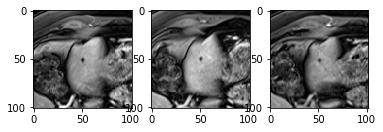

In [61]:
cls = "cyst"
accnum = "12207268"
img = np.load(C.crops_dir + cls + "\\" + accnum + "_0.npy")
hf.plot_section_auto(img)

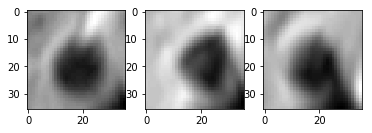

In [58]:
cls = "cyst"
accnum = "12042703"
img = np.load(C.orig_dir + cls + "\\" + accnum + "_0.npy")
hf.plot_section_auto(img)

In [ ]:
cls = "cyst"
accnum = "12042703"
img = np.load(C.aug_dir + cls + "\\" + accnum + "_0_0.npy")
hf.plot_section_auto(img)

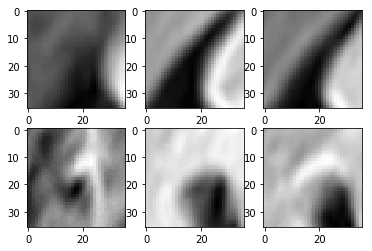

In [17]:
hf.plot_section_scan(img, 0.9)

img_fn = "E100529980.npy"
img = np.load(C.full_img_dir+"\\"+img_fn)
hf.plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)
#art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]

#img = np.load("orig_imgs\\cyst\\E100529980_1.npy")
#plt.imshow(img[:,:,5,0], cmap='gray')

hf.augment(pad_img, C.dims, translate=[1,1,0], exceed_ratio=0.9, num_samples=1)